# Ant Colony Optimization on Undirected Graphs
Ant Colony Optimization (ACO) is a class of optimization techniques based on the foraging behavior of ants. This project implements the ACO algorithm AntNet, developed by Gianni Di Caro and Marco Dorigo, in python.

These methods can be extended to a number of different applications, but we will be focusing on finding the shortest path between nodes on an undirected graph. This has uses in the realm of computer network optimization. Servers send out data in discrete "packets" through the wide web of connected servers, and the goal is to find the most efficient path for these packets between the server host and reciever.

Say we have a graph that we do not know the nature of. All we are provided are the weights between nodes (also referred to as distance). We will represent this as a randomly generated graph of nodes with random weights. The code below creates the graph and visualizes it.


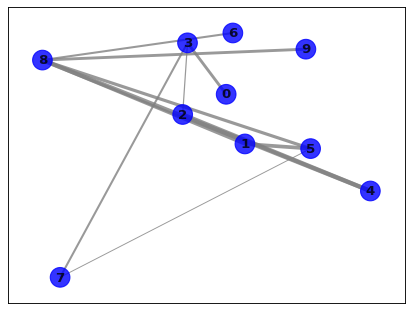

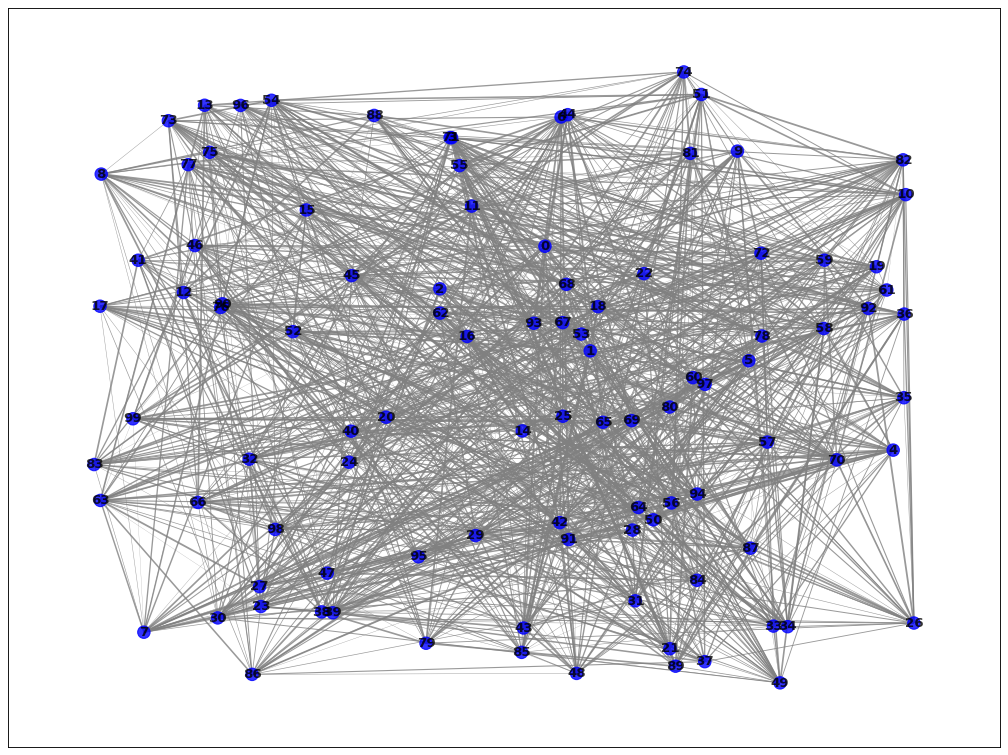

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def create_random_graph(n, weight_range=(1, 10), edge_probability=0.3):
    """
    Creates a random undirected graph with n nodes. G is a NetworkX Graph object. Returns its adjacency list.

    Parameters:
    - n: Number of nodes.
    - weight_range: Tuple indicating the range of edge weights (inclusive).
    - edge_probability: Probability of an edge existing between any two nodes.

    Returns:
    - adj_matrix: A 2D list representing the adjacency matrix.
    """
    G = nx.Graph()  # Initialize an undirected graph

    # Add nodes
    for i in range(n):
        G.add_node(i)

    # Add edges with random weights
    for i in range(n):
        for j in range(i + 1, n):  # Avoid duplicate edges
            if random.random() < edge_probability:
                weight = random.randint(*weight_range)
                G.add_edge(i, j, weight=weight)

   # Convert to numpy array
    adj_matrix = nx.to_numpy_array(G, weight='weight')  # Include edge weights
    return adj_matrix.tolist()

def visualize_graph(graph, size, best_path = False):
    
        if best_path:
            show_route = True
            edges_to_highlight = [(best_path[i], best_path[i + 1]) if best_path[i] < best_path[i + 1] else (best_path[i + 1], best_path[i]) for i in range(len(best_path) - 1)]
        else:
            show_route = False
        
        # Adjacency matrix to numpy array to NetworkX graph
        graph_x = nx.from_numpy_array(np.array(graph))

        # Not all graphs can be drawn planar, but if it can, then use that positional layout
        if nx.is_planar(graph_x):
            pos = nx.planar_layout(graph_x)
        else:
            pos = nx.spring_layout(graph_x)

        # Specify custom colors for nodes and edges
        if show_route:
            node_colors = ['red' if node in best_path else 'blue' for node in graph_x.nodes()]
            edge_colors = ['red' if edge in edges_to_highlight else 'gray' for edge in graph_x.edges()]
        else:
            node_colors = ['blue'] * len(graph)
            edge_colors = ['gray'] * len(graph)

        # Extract weights and scale them for line thickness
        edge_weights = [graph_x[u][v]['weight'] for u, v in graph_x.edges()]
        edge_thickness = [0.1 + 1.5 * (100/size) * weight / max(edge_weights) for weight in edge_weights]  # Scaled thickness

        # Draw the graph
        
        plt.figure(figsize=(16 * size/100, 12 * size/100), dpi=80)
        
        nx.draw_networkx(
            graph_x,
            pos = nx.random_layout(graph_x, seed=0),
            with_labels=True,
            node_color=node_colors,
            edge_color=edge_colors,
            node_size=125 * (100/size),
            font_color='black',
            font_size=12,
            font_weight='bold',
            width=edge_thickness,
            alpha = 0.80
        )
        
        plt.show()

# Initialize graphs
graph1 = create_random_graph(10, weight_range=(1, 15), edge_probability=0.2)
graph2 = create_random_graph(100, weight_range=(1, 15), edge_probability=0.25)

visualize_graph(graph1, size=40)
visualize_graph(graph2, size=100)

Two example graphs of 10 and 100 nodes respectively. The line thickness represents the weight or distance between nodes, with thicker lines having more weight. We want to optimize the distance travelled between 2 arbitrary nodes on this graph. To find the exact shortest path, we would need to evaluate every possible combination, which scales very quickly with increasing nodes. Dijkstra's algorithm is pretty good at solving this, but we wish to implement ACO, which outperforms it in certain cases.

# The Algorithm in a Nutshell

ACO operates by placing virtual "ants" on the graph, and iteratively lets them search for an ideal path until it is found. The ants will follow a heuristic function which can be scaled by a parameter. Here our heuristic function is simply a measure of the weight between every node adjacent to the current node the ant is on. The ant has a random probability of travelling to any adjacent node, but has a bias to the connections with less weight based on our heuristic input parameter. After the ant has completed its journey to the destination, it leaves a trail of virtual "pheromones" akin to real ants. "Good" paths, or those with smaller total distances accumulated, are indicated to the next round of ants by way of these pheromones. As the ants forage, the pheromones are built up on the optimal path, giving our result.

The code below implements this algorithm in the class AntNet.

In [82]:
class AntNet:
    def __init__(self, graph, num_ants, alpha=2, beta=2, evaporation_rate=0.5, iterations=100, exploration_prob=0.1):
        self.graph = graph  # Graph represented as adjacency matrix
        self.num_nodes = len(graph)
        self.num_ants = num_ants
        self.alpha = alpha  # Pheromone influence
        self.beta = beta  # Heuristic influence
        self.evaporation_rate = evaporation_rate
        self.iterations = iterations
        self.exploration_prob = exploration_prob  # Probability of random exploration
        self.pheromone = np.ones((self.num_nodes, self.num_nodes)) * 0.1  # Initialize pheromones with a small positive value to encourage exploration
        self.best_path = None
        self.best_cost = float('inf')

    def heuristic(self, node, neighbor):
        """Inverse of the distance as heuristic."""
        distance = self.graph[node][neighbor]
        epsilon = 1e-3  # Small constant to avoid division by zero
        if distance == 0:  # Handle cases where there's no direct connection
            return 0  # Treat as a blocked path
        return 1 / (distance + epsilon)

    def probabilistic_choice(self, node, unvisited):
        """Select next node probabilistically,with a chance for exploration."""
        probabilities = []
        for neighbor in unvisited:
            if self.graph[node][neighbor] == 0:
                probabilities.append(0)  # No path available
            else:
                tau = self.pheromone[node][neighbor] ** self.alpha
                eta = self.heuristic(node, neighbor) ** self.beta
                probabilities.append(tau * eta)

        if sum(probabilities) == 0:  # No valid paths
            return random.choice(list(unvisited))  # Choose a random unvisited node

        probabilities = np.array(probabilities) / (sum(probabilities) + 1e-6)  # Avoid division by zero
        return random.choices(list(unvisited), weights=probabilities, k=1)[0]

    def generate_ant_path(self, start, end):
        """Simulate a single ant's path."""
        current_node = start
        path = [current_node]
        cost = 0
        unvisited = set(range(self.num_nodes)) - {start}

        while unvisited:
            next_node = self.probabilistic_choice(current_node, unvisited)
            if self.graph[current_node][next_node] == 0:  # Handle blocked path
                unvisited.remove(next_node)  # Remove this blocked node from consideration
                continue
            path.append(next_node)
            cost += self.graph[current_node][next_node]
            current_node = next_node
            unvisited.remove(next_node)
            if current_node == end:
                break

        if current_node != end:
            return None, float('inf')  # Invalid path if the ant doesn't reach the destination

        return path, cost

    def update_pheromone(self, all_paths):
        """Update pheromone levels based on ants' paths."""
        self.pheromone *= (1 - self.evaporation_rate)  # Evaporation
        for path, cost in all_paths:
            pheromone_deposit = 1 / (cost + 1e-6) if cost > 0 else 0  # Avoid division by zero
            for i in range(len(path) - 1):
                self.pheromone[path[i]][path[i + 1]] += pheromone_deposit  # Reinforcement

    def optimize(self, start, end):
        """Run the AntNet optimization."""
        for iteration in range(self.iterations):
            all_paths = []
            for ant in range(self.num_ants):
                path, cost = self.generate_ant_path(start, end)
                if path:
                    all_paths.append((path, cost))
                    if cost < self.best_cost:
                        self.best_cost = cost
                        self.best_path = path
            self.update_pheromone(all_paths)

        return self.best_path, self.best_cost

Now we can work with our graphs from before and find the best path using ACO. Let's also compare the resulting path with Dijkstra's algorithm to see if ACO performs as well.

Graph 1:
ACO Best Path: [0, 3, 7, 5, 8, 9]
ACO Best Cost: 41.0

Dijkstra shortest path: [0, 3, 7, 5, 8, 9]
Dijkstra path cost: 41.0


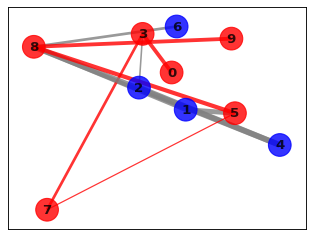

Graph 2:
ACO Best Path: [0, 47, 7, 99]
ACO Best Cost: 8.0

Dijkstra shortest path: [0, 21, 37, 60, 11, 9]
Dijkstra path cost: 11.0


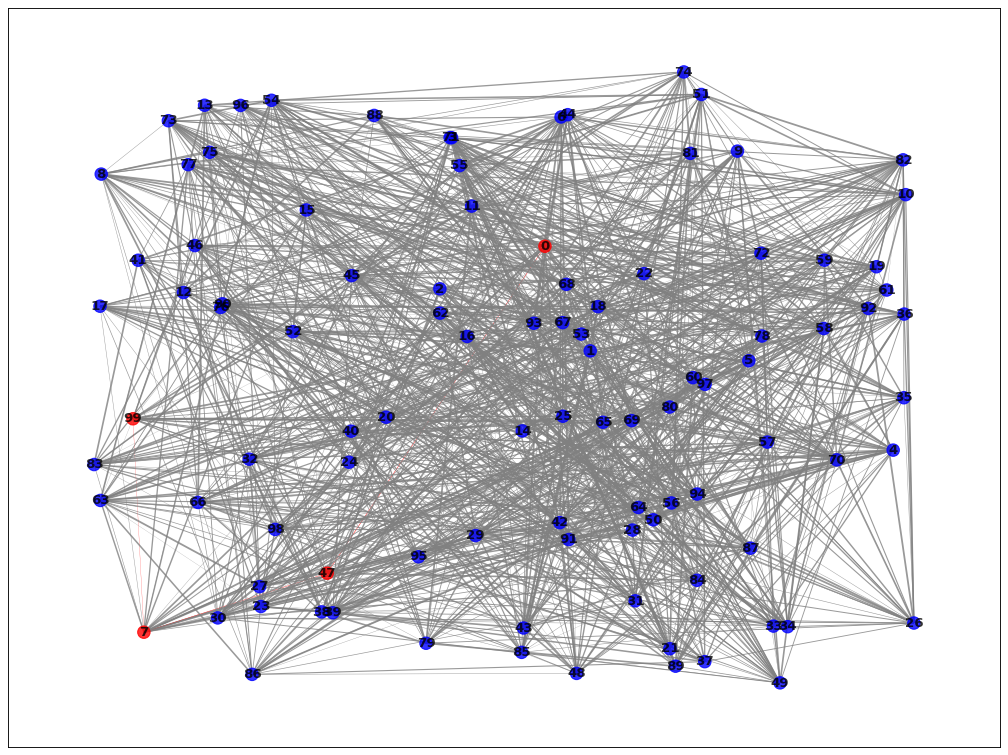

In [96]:
# Run the algorithm on graph 1
ant_net_1 = AntNet(graph1, num_ants=50, alpha=2, beta=2, evaporation_rate=0.5, iterations=100, exploration_prob=0.15)
best_path, best_cost = ant_net_1.optimize(start=0, end=9)

print("Graph 1:")
print("ACO Best Path:", best_path)
print("ACO Best Cost:", best_cost)

# Use Dijkstra algorithm from networkx library on graph 1
dijkstra_path_1 = nx.dijkstra_path(nx.from_numpy_array(np.array(graph1)), source=0, target=9)
dijkstra_cost_1 = nx.path_weight(nx.from_numpy_array(np.array(graph1)), dijkstra_path_1, 'weight')
print(f'\nDijkstra shortest path: {dijkstra_path_1}')
print(f'Dijkstra path cost: {dijkstra_cost_1}')

visualize_graph(graph1, size=30, best_path=best_path)


# Run the algorithm on graph 2
ant_net_2 = AntNet(graph2, num_ants=200, alpha=2, beta=2, evaporation_rate=0.5, iterations=100, exploration_prob=0.15)
best_path, best_cost = ant_net_2.optimize(start=0, end=99)

print("Graph 2:")
print("ACO Best Path:", best_path)
print("ACO Best Cost:", best_cost)

# Use Dijkstra algorithm from networkx library on graph 2
dijkstra_path_2 = nx.dijkstra_path(nx.from_numpy_array(np.array(graph2)), source=0, target=9)
dijkstra_cost_2 = nx.path_weight(nx.from_numpy_array(np.array(graph2)), dijkstra_path_2, 'weight')
print(f'\nDijkstra shortest path: {dijkstra_path_2}')
print(f'Dijkstra path cost: {dijkstra_cost_2}')

visualize_graph(graph2, size=100, best_path=best_path)

# Scalability
Let's try an even larger graph to see how it performs

Graph 3:
ACO Best Path: [0, 645, 882, 688, 1999]
ACO Best Cost: 23.0

Dijkstra shortest path: [0, 1947, 426, 330, 228, 41, 262, 9]
Dijkstra path cost: 24.0


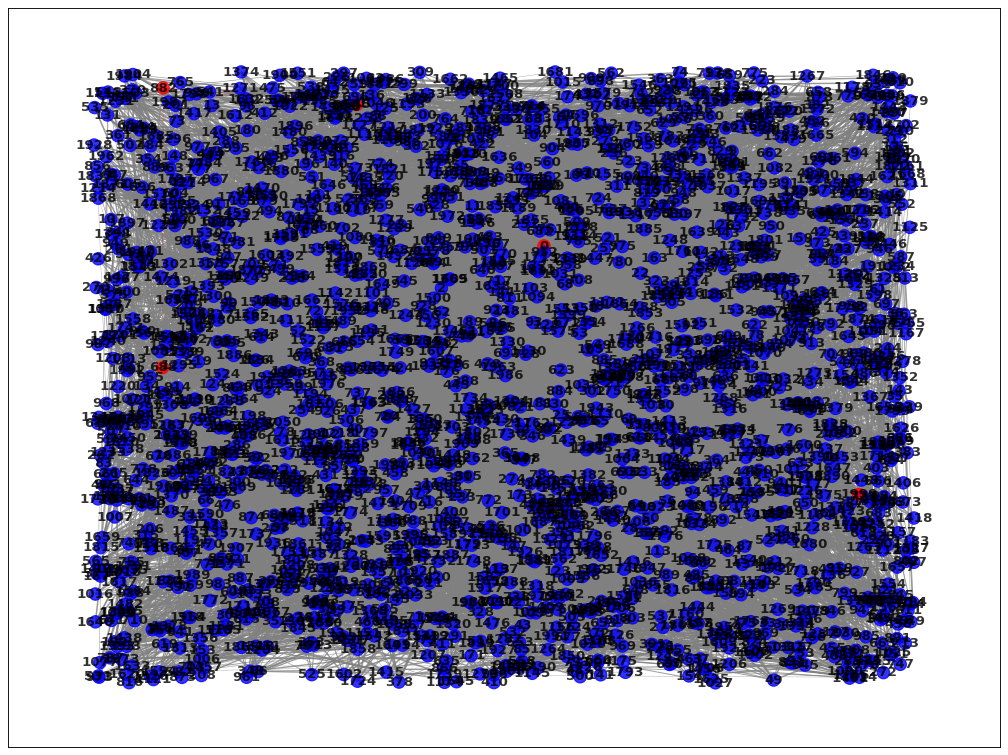

In [98]:
# Initialize graph with 2000 nodes
n_nodes = 2000
graph3 = create_random_graph(n_nodes, weight_range=(1, 20), edge_probability=0.005)


# Run the algorithm on graph 3
ant_net_3 = AntNet(graph3, num_ants=200, alpha=2, beta=2, evaporation_rate=0.5, iterations=100, exploration_prob=0.15)
best_path, best_cost = ant_net_3.optimize(start=0, end=1999)

print("Graph 3:")
print("ACO Best Path:", best_path)
print("ACO Best Cost:", best_cost)

# Use Dijkstra algorithm from networkx library on graph 2
dijkstra_path_3 = nx.dijkstra_path(nx.from_numpy_array(np.array(graph3)), source=0, target=9)
dijkstra_cost_3 = nx.path_weight(nx.from_numpy_array(np.array(graph3)), dijkstra_path_3, 'weight')
print(f'\nDijkstra shortest path: {dijkstra_path_3}')
print(f'Dijkstra path cost: {dijkstra_cost_3}')

visualize_graph(graph3, size=100, best_path=best_path)